In [73]:
import torch as torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler
import mlflow
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [74]:
df = pd.read_csv("../data/2-processed/processed.csv")
df.dropna(inplace=True)
df

,views,sentiment_score,close,volume,return,rolling_mean_7,rolling_mean_14,rolling_std_7,rolling_std_14,day,month,year
13,94414,0.220994,255.19,6029760.0,0.019711,0.001496,0.003449,0.017456,0.014636,2,7,2014
14,176951,0.571429,257.70,5029670.0,0.009740,-0.000166,0.002182,0.015715,0.013081,3,7,2014
15,194270,0.102740,253.90,5432990.0,-0.014967,0.002159,0.000087,0.010782,0.013326,4,7,2014
16,241041,1.444687,248.99,6265420.0,-0.019720,-0.000223,-0.000836,0.013597,0.014255,7,7,2014
17,135575,0.039216,249.99,7000330.0,0.004000,0.000206,-0.000345,0.013689,0.014298,8,7,2014
...,...,...,...,...,...,...,...,...,...,...,...,...
2890,306503,0.944193,409.65,3688415.0,0.018064,0.003261,-0.000189,0.018008,0.014195,15,12,2025
2891,70523,0.432692,413.00,3507863.0,0.008111,0.000935,0.000881,0.015732,0.014217,16,12,2025
2892,129196,0.244898,411.45,2995120.0,-0.003767,0.002879,0.001806,0.013818,0.013380,17,12,2025
2893,152050,0.094340,409.25,5504714.0,-0.005376,0.000343,0.000664,0.013407,0.013252,18,12,2025


In [75]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, step, target_col, feature_col, scaler_features, scaler_target):
        self.seq_len = seq_len
        self.step = step

        self.features = data[feature_col].values.astype(np.float32)
        self.target = data[target_col].values.astype(np.float32).reshape(-1, 1)

        # scaler 
        self.scaler_features = scaler_features
        self.scaler_target = scaler_target

        self.features = self.scaler_features.transform(self.features)
        self.target = self.scaler_target.transform(self.target) 

        #self.feature_means = np.mean(self.features, axis=0)
        #self.feature_vars = np.var(self.features, axis=0)

    
    def __len__(self):
        return (len(self.features) - self.seq_len) // self.step
    
    
    def __getitem__(self, idx):
        start_idx = idx * self.step
        end_idx = start_idx + self.seq_len

        x = self.features[start_idx:end_idx]
        y = self.target[end_idx]

        return torch.from_numpy(x), torch.from_numpy(y)

In [ ]:
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

def smooth_param(df):
    df['views_mod'] = (df['views'].ewm(alpha=0.02).mean() / df['views'].mean()).apply(lambda x: x / (1 + np.abs(x)))
    df['sentiment_score_mod'] = df['sentiment_score'].ewm(alpha=0.02).mean()
    return df

train_df = smooth_param(train_df)
test_df = smooth_param(test_df)

features = ['sentiment_score_mod', 'views_mod', 'rolling_mean_14', 'rolling_std_14', 'month']
target = ['close']

seq_len = 15
step = 2
scaler_features = StandardScaler().fit(train_df[features])
scaler_target = StandardScaler().fit(train_df[target])

batch_size = 32
#   -   #   -   #   -   #   -   #   -   #

train_ds = TimeSeriesDataset(data=train_df,
                             seq_len=seq_len,
                             step=step,
                             target_col=target,
                             feature_col=features,
                             scaler_features=scaler_features,
                             scaler_target=scaler_target)

val_ds = TimeSeriesDataset(data=test_df,
                           seq_len=seq_len,
                           step=step,
                           target_col=target,
                           feature_col=features,
                           scaler_features=scaler_features,
                           scaler_target=scaler_target)


train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

C:\Users\Ваня\AppData\Local\Temp\ipykernel_2496\4234337171.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['views_mod'] = (df['views'].ewm(alpha=0.02).mean() / df['views'].mean()).apply(lambda x: x / (1 + np.abs(x) * 0.05))
C:\Users\Ваня\AppData\Local\Temp\ipykernel_2496\4234337171.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_score_mod'] = df['sentiment_score'].ewm(alpha=0.02).mean()
C:\Users\Ваня\AppData\Local\Temp\ipykernel_2496\4234337171.py:6: SettingWithCopyWarning: 
A value

In [77]:
class GRUPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.2):
        super(GRUPredictor, self).__init__()
        
        self.gru = nn.GRU(
            input_size=input_dim, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_len, input_dim)
        # out: (batch_size, seq_len, hidden_dim)
        out, _ = self.gru(x)
        
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
def calculate_mse(model, val_loader):
    model.eval() # Переводим модель в режим оценки
    predictions = []
    actuals = []

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            outputs = model(x_batch)
            predictions.append(outputs.numpy())
            actuals.append(y_batch.numpy())

    predictions = np.concatenate(predictions, axis=0).flatten()
    actuals = np.concatenate(actuals, axis=0).flatten()

    predictions = scaler_target.inverse_transform(predictions.reshape(-1, 1)).flatten()
    actuals = scaler_target.inverse_transform(actuals.reshape(-1, 1)).flatten()

    return mean_squared_error(predictions, actuals)

def calculate_hit_rate(model, val_loader):
    model.eval() # Переводим модель в режим оценки
    predictions = []
    actuals = []

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            outputs = model(x_batch)
            predictions.append(outputs.numpy())
            actuals.append(y_batch.numpy())

    predictions = np.concatenate(predictions, axis=0).flatten()
    actuals = np.concatenate(actuals, axis=0).flatten()

    y_pred = scaler_target.inverse_transform(predictions.reshape(-1, 1)).flatten()
    y_true = scaler_target.inverse_transform(actuals.reshape(-1, 1)).flatten()

    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    true_diff = np.diff(y_true)
    pred_diff = np.diff(y_pred)
    
    true_direction = true_diff > 0
    pred_direction = pred_diff > 0
    
    hits = (true_direction == pred_direction).sum()
    
    # 3. Итоговая метрика
    hit_rate = hits / len(y_true)
    return hit_rate

In [79]:
def train(model, train_loader, val_loader, epochs, lr, weight_decay, params_to_log=None):
    if mlflow.active_run():
        mlflow.end_run()

    with mlflow.start_run() as run:
        mlflow.log_param("lr", lr)
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("weight_decay", weight_decay)
        if params_to_log:
            mlflow.log_params(params_to_log)

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        all_preds = []
        all_targets = []

        for epoch in range(epochs):
            model.train()
            train_loss = 0
            for x_batch, y_batch in train_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                optimizer.zero_grad()
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            model.eval()
            val_loss = 0
            with torch.no_grad():
                for x_val, y_val in val_loader:
                    x_val, y_val = x_val.to(device), y_val.to(device)
                    preds = model(x_val)
                    val_loss += criterion(preds, y_val).item()
                    all_preds.append(preds)
                    all_targets.append(y_val)
            
            all_preds_flat = torch.cat(all_preds).cpu().numpy().flatten()
            all_targets_flat = torch.cat(all_targets).cpu().numpy().flatten()
            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)
            mlflow.log_metric("train_loss", avg_train_loss, step=epoch)
            mlflow.log_metric("val_loss", avg_val_loss, step=epoch)

            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}')

        mse = calculate_mse(model, val_loader)
        hr = calculate_hit_rate(model, val_loader)
        mlflow.log_metric("RMSE", mse**0.5)
        mlflow.log_metric("hit_rate", hr)
        mlflow.pytorch.log_model(model, name="model")

In [ ]:
mlflow.set_experiment("Stock-Analysis-LSTM")
model_params = {'hidden_dim': 64, 'num_layers': 4}
model = GRUPredictor(input_dim=len(features), 
                     hidden_dim=model_params['hidden_dim'], 
                     num_layers=model_params['num_layers'], 
                     output_dim=1)

train(model=model, 
      train_loader=train_loader, 
      val_loader=val_loader, 
      epochs=50, 
      lr=1e-4,
      weight_decay=1e-5,
      params_to_log=model_params)

Epoch 1/30 | Train Loss: 1.070303 | Val Loss: 2.255601
Epoch 2/30 | Train Loss: 1.013269 | Val Loss: 2.152023
Epoch 3/30 | Train Loss: 1.006946 | Val Loss: 2.060113
Epoch 4/30 | Train Loss: 0.988082 | Val Loss: 1.904470
Epoch 5/30 | Train Loss: 0.912949 | Val Loss: 1.437880
Epoch 6/30 | Train Loss: 0.751257 | Val Loss: 0.873700
Epoch 7/30 | Train Loss: 0.654325 | Val Loss: 0.796444
Epoch 8/30 | Train Loss: 0.618775 | Val Loss: 0.782238
Epoch 9/30 | Train Loss: 0.603296 | Val Loss: 0.771491
Epoch 10/30 | Train Loss: 0.593654 | Val Loss: 0.761501
Epoch 11/30 | Train Loss: 0.594838 | Val Loss: 0.763336
Epoch 12/30 | Train Loss: 0.585303 | Val Loss: 0.755653
Epoch 13/30 | Train Loss: 0.584144 | Val Loss: 0.751921
Epoch 14/30 | Train Loss: 0.577032 | Val Loss: 0.749041
Epoch 15/30 | Train Loss: 0.572521 | Val Loss: 0.743048
Epoch 16/30 | Train Loss: 0.570917 | Val Loss: 0.737086
Epoch 17/30 | Train Loss: 0.563616 | Val Loss: 0.730871
Epoch 18/30 | Train Loss: 0.564092 | Val Loss: 0.727186
E

In [81]:
def plot_predictions(model, val_loader):
    model.eval() # Переводим модель в режим оценки
    predictions = []
    actuals = []

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            outputs = model(x_batch)
            
            # Сохраняем результаты
            predictions.append(outputs.numpy())
            actuals.append(y_batch.numpy())

    predictions = np.concatenate(predictions, axis=0).flatten()
    actuals = np.concatenate(actuals, axis=0).flatten()

    predictions = scaler_target.inverse_transform(predictions.reshape(-1, 1)).flatten()
    actuals = scaler_target.inverse_transform(actuals.reshape(-1, 1)).flatten()

    plt.figure(figsize=(12, 6))

    plt.plot(actuals, color='blue', label='test', alpha=0.4)
    plt.scatter(range(len(actuals)), actuals, color='blue', s=10)

    # Рисуем предсказания (красные точки)
    plt.scatter(range(len(predictions)), predictions, color='red', 
                label='predict', s=10, marker='x')

    plt.title('Поточечное сравнение прогнозов GRU с реальностью')
    plt.xlabel('Временные интервалы (Index)')
    plt.ylabel('Цена')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.show()

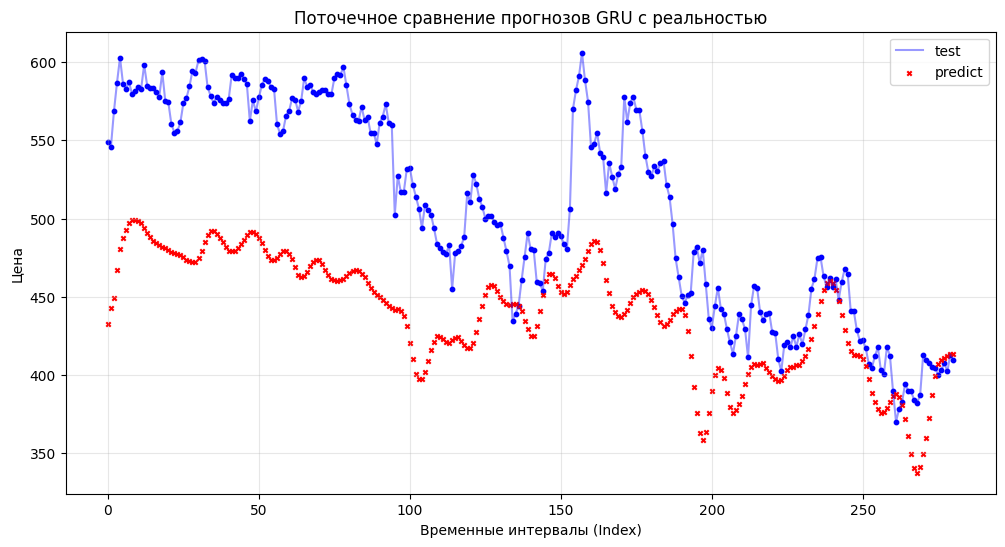

In [85]:
plot_predictions(model, val_loader)

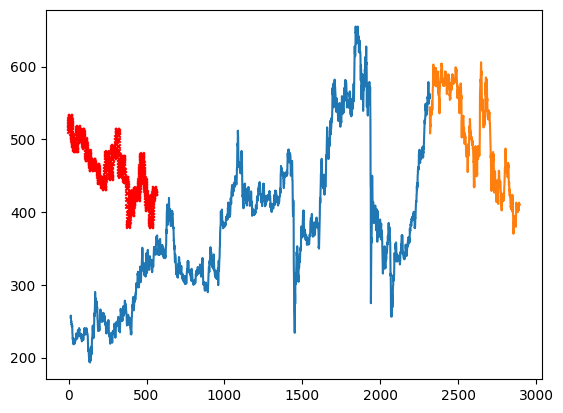

In [83]:
train_df['close'].plot()
test_df['close'].plot()
plt.scatter(range(len(predictions)), predictions, color='red', 
            label='Предсказания модели', s=10, marker='x')